In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='tensorflow' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Concatenate
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

Using TensorFlow backend.


In [2]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [3]:
MAX_SEQUENCE_LENGTH = 50
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.7

In [4]:
# reading data

df = pd.read_csv('data/train.tsv', sep='\t')
# df = pd.read_excel('dataset.')
df = df.dropna()
df = df.reset_index(drop=True)
macronum=sorted(set(df['Sentiment']))
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['Sentiment'])))

texts = df.Phrase
labels = df.Sentiment

('Shape of dataset ', (156060, 4))
Index([u'PhraseId', u'SentenceId', u'Phrase', u'Sentiment'], dtype='object')
('No. of unique classes', 5)


In [5]:
# macronum=sorted(set(df['Sentiment']))
# print macronum
# macro_to_id = dict((note, number) for number, note in enumerate(macronum))

# def fun(i):
#     return macro_to_id[i]

# df['class']=df['class'].apply(fun)

In [6]:
# texts = df.Phrase
# labels = df.Sentiment


# for idx in range(df.Phrase.shape[0]):
#     text = BeautifulSoup(df.message[idx])
#     texts.append(clean_str(str(text.get_text().encode())))

# for idx in data_train['class']:
#     labels.append(idx)

In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))
print('Maximum sequence LENGTH', max(map(lambda x: len(x), sequences)))

('Number of Unique Tokens', 15288)
('Maximum sequence LENGTH', 49)


In [8]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

('Shape of Data Tensor:', (156060, 50))
('Shape of Label Tensor:', (156060, 5))


In [9]:
embeddings_index = {}
f = open('/Users/victor/Downloads/glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [10]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## HERE
embedding_layer = Embedding(input_dim = len(word_index) + 1,
                            output_dim = EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH, 
                            trainable=True)

In [42]:
## HERE
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov11= Conv1D(64, 5, activation='tanh')(embedded_sequences)
l_cov12= Conv1D(64, 5, activation='relu')(embedded_sequences)
l_cov_concat = Concatenate(axis=-1)([l_cov11, l_cov12])

l_pool1 = MaxPooling1D(5)(l_cov_concat)
# l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(256, 5, activation='tanh')(l_pool1)
l_pool3 = MaxPooling1D(5)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
preds = Dense(len(macronum), input_shape=(5,5), activation='softmax')(l_flat)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
#              categorical_crossentropy 
              optimizer='adam',
#               rmsprop
              metrics=['acc', 'categorical_accuracy'])

print("Simplified convolutional neural network")
from keras.utils import plot_model
plot_model(model, to_file='model.png')

model.summary()
cp=ModelCheckpoint('model_cnn.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

Simplified convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 100)      1528900     input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 46, 64)       32064       embedding_1[9][0]                
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 46, 64)       32064       embedding_1[9][0]                
_____________________________________________________________________

In [43]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=500, callbacks=[cp])

Train on 46818 samples, validate on 109242 samples
Epoch 1/7
46818/46818 [==============================] - 30s 637us/step - loss: 0.8600 - acc: 0.6732 - categorical_accuracy: 0.6732 - val_loss: 1.1619 - val_acc: 0.5975 - val_categorical_accuracy: 0.5975

Epoch 00001: val_acc improved from -inf to 0.59754, saving model to model_cnn.hdf5
Epoch 2/7
46818/46818 [==============================] - 29s 623us/step - loss: 0.5179 - acc: 0.8017 - categorical_accuracy: 0.8017 - val_loss: 1.4180 - val_acc: 0.5881 - val_categorical_accuracy: 0.5881

Epoch 00002: val_acc did not improve from 0.59754
Epoch 3/7
46818/46818 [==============================] - 28s 607us/step - loss: 0.4306 - acc: 0.8348 - categorical_accuracy: 0.8348 - val_loss: 1.6330 - val_acc: 0.5905 - val_categorical_accuracy: 0.5905

Epoch 00003: val_acc did not improve from 0.59754
Epoch 4/7
46818/46818 [==============================] - 28s 605us/step - loss: 0.3914 - acc: 0.8527 - categorical_accuracy: 0.8527 - val_loss: 1.7719 

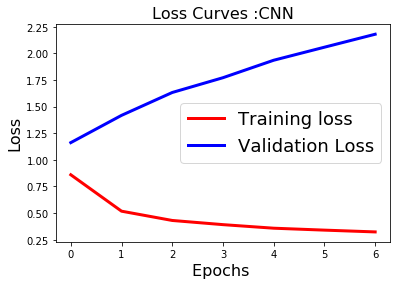

In [44]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

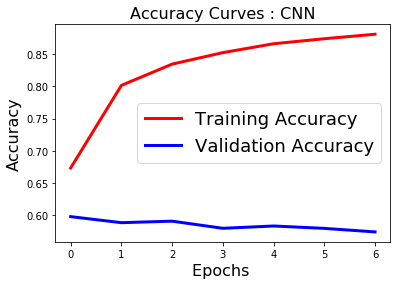

In [45]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# from PIL import Image
# display(Image.open('cnn_model.png'))